fix so only looks when all players are past half court on offense

x look into distances vs win pct

x count possessions

look into velocity

number of passes?

x heatmap of transition matrix

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import scipy.stats
import time

### Load in data

In [2]:
with open("id_to_player.json") as f:
    for l in f:
        id_to_player = json.loads(l)
id_to_player = {int(k): v for (k, v) in id_to_player.items()}
with open("player_to_id.json") as f:
    for l in f:
        player_to_id = json.loads(l)
player_to_id = {k: int(v) for (k, v) in player_to_id.items()}

In [3]:
#id_to_team = {}
# team_to_id = {}
# for root, dirs, files in os.walk(".\data"):
#     if len(id_to_team) == 30:
#         break
#     for fil in files:
#         with open(os.path.join(root, fil)) as f:
#             for l in f:
#                 line = json.loads(l)
#                 home_id = line["events"][0]["home"]["teamid"]
#                 home_name = line["events"][0]["home"]["name"]
#                 away_id = line["events"][0]["visitor"]["teamid"]
#                 away_name = line["events"][0]["visitor"]["name"]
#                 id_to_team[home_id] = home_name
#                 id_to_team[away_id] = away_name
#                 team_to_id[home_name] = home_id
#                 team_to_id[away_name] = away_id
#                 break

# with open("id_to_team.json", "w") as f:
#     json.dump(id_to_team, f)
# with open("team_to_id.json", "w") as f:
#     json.dump(team_to_id, f)

with open("id_to_team.json") as f:
    for l in f:
        id_to_team = json.loads(l)
id_to_team = {int(k): v for (k, v) in id_to_team.items()}        
with open("team_to_id.json") as f:
    for l in f:
        team_to_id = json.loads(l)
team_to_id = {k: int(v) for (k, v) in team_to_id.items()}
team_to_winpct = json.load(open("team_to_winpct.json"))
team_to_abbrev = json.load(open("team_to_abbrev.json"))

### Zones
<img src="zones.png">

### Function to find distance from one point to another

In [4]:
def distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

### Function to return the zone of a given coordinate

In [5]:
def get_zone(x, y):
    if x < 0 or x > 94:
        return 0
    elif 19 <= y <= 31 and (x < 19 or x > 75):
        return 1 
    elif (0 <= x <= 14 or 80 <= x <= 94) and 0 <= y <= 3:
        return 2
    elif (0 <= x <= 14 or 80 <= x <= 94) and 47 <= y <= 50:
        return 3
    elif (0 <= x <= 14 or 80 <= x <= 94) and 3 < y < 19:
        return 4
    elif (0 <= x <= 14 or 80 <= x <= 94) and 31 < y < 47:
        return 5
    elif ((x < 47 and (x-5.25)**2 + (y-25)**2 < 23.75**2) or (x >= 47 and (x-88.75)**2 + (y-25)**2 < 23.75**2)) and y <= 25:
        return 6
    elif ((x < 47 and (x-5.25)**2 + (y-25)**2 < 23.75**2) or (x >= 47 and (x-88.75)**2 + (y-25)**2 < 23.75**2)) and y > 25:
        return 7
    elif y <= 25:
        return 8
    else:
        return 9

### Function to output transition matrices for a team's movements 

In [6]:
def transitions(team_name, num_games=None):
    abbrev = team_to_abbrev[team_name]
    team_id = team_to_id[team_name]
    transition_dict = {}
    seen_moments = set()

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return transition_dict
                    print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    for val in mom[5]:
                                        player = val[1]
                                        team = val[0]
                                        if team == team_id and player != -1:
                                            zone = get_zone(val[2], val[3])
                                            if team not in transition_dict:
                                                transition_dict[team] = {}
                                            if player not in transition_dict[team]:
                                                transition_dict[team][player] = [np.zeros(shape=(10, 10)), zone]
                                            else:
                                                if transition_dict[team][player][1] != zone:
                                                    transition_dict[team][player][0][transition_dict[team][player][1], zone] += 1
                                            transition_dict[team][player][1] = zone
                                    seen_moments.add(mom_tuple)
    return transition_dict

### Outputs distances from each player to ball for each moment

In [7]:
def distances_to_ball(team_name, team_specific=True, num_games=None, p=True):
    #p = scipy.stats.norm(1, 1)
    abbrev = team_to_abbrev[team_name]
    moment_dists = []
    team_id = team_to_id[team_name]
    seen_moments = set()

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return moment_dists
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    ballx = mom[5][0][2]
                                    bally = mom[5][0][3]
                                    dists = []
                                    for val in mom[5]:
                                        team = val[0]
                                        player = val[1]
                                        if player != -1 and player != 0 and (not team_specific or (team == team_id and team_specific)):
                                            dists.append((id_to_player[player], distance(val[2], val[3], ballx, bally), team))
                                            #dists.append((id_to_player[player], p.pdf(distance(val[2], val[3], ballx, bally))))
                                    seen_moments.add(mom_tuple)
                                    if dists:
                                        moment_dists.append(sorted(dists, key=lambda x:x[1]))
    return moment_dists

### Given moments, finds ballhandlers

In [8]:
def get_ballhandlers(moment_dists):
    ballhandlers = []
    for i, mom in enumerate(moment_dists):
        if mom[0][1] > 3:
            team = None
            ballhandler = None
            for j in range(i-1, i-5, -1):
                if j < 0:
                    break
                if ballhandlers[j][0] is None:
                    for ind in range(j, i):
                        ballhandlers[ind] = (None, ballhandlers[ind][1], None)
        else:
            if i == 0 or i > 0 and mom[0][0] == moment_dists[i-1][0][0]:
                ballhandler = mom[0][0]
                team = mom[0][2]
                if i > 0 and ballhandlers[i-1][0] is None:
                    for j in range(i-1, i-5, -1):
                        if j < 0:
                            break
                        if ballhandlers[j][0] == ballhandler:
                            for ind in range(j, i):
                                ballhandlers[ind] = (ballhandler, ballhandlers[ind][1], team)
            else:
                ballhandler = None
                team = None
        ballhandlers.append((ballhandler, mom[0][1], team))
    return ballhandlers

### Finds transition matrices of ballhandlers only

In [9]:
def ballhandler_transitions(team_name, ballhandlers, num_games=None, p=True):
    abbrev = team_to_abbrev[team_name]
    team_id = team_to_id[team_name]
    b_transition_dict = {}
    seen_moments = set()

    moment_num = 0
    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return b_transition_dict
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            last_bh = None
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                if mom_tuple not in seen_moments:
                                    for val in mom[5]:
                                        team = val[0]
                                        player = val[1]
                                        if moment_num >= len(ballhandlers):
                                            return b_transition_dict
                                        if team == team_id and player != -1 and id_to_player[player] == ballhandlers[moment_num][0]:
                                            zone = get_zone(val[2], val[3])
#                                             if zone == 0:
#                                                 print val[2], val[3], id_to_player[player]
                                            if team not in b_transition_dict:
                                                b_transition_dict[team] = {}
                                            if player not in b_transition_dict[team]:
                                                b_transition_dict[team][player] = [np.zeros(shape=(11, 11)), zone]
                                            else:
                                                if b_transition_dict[team][player][1] != zone:
                                                    b_transition_dict[team][player][0][b_transition_dict[team][player][1], zone] += 1
                                            b_transition_dict[team][player][1] = zone
                                        elif team == team_id and player != -1 and ballhandlers[moment_num][0] is None and last_bh is not None:
                                            player = player_to_id[last_bh]
                                            b_transition_dict[team][player][0][b_transition_dict[team][player][1], 10] += 1
                                    last_bh = ballhandlers[moment_num][0]       
                                    moment_num += 1
                                    seen_moments.add(mom_tuple)
    return b_transition_dict

In [44]:
dists = distances_to_ball("Golden State Warriors")

.\data\01.02.2016.DEN.at.GSW
.\data\01.04.2016.CHA.at.GSW
.\data\01.05.2016.GSW.at.LAL
.\data\01.08.2016.GSW.at.POR
.\data\01.09.2016.GSW.at.SAC
.\data\01.11.2016.MIA.at.GSW
.\data\01.13.2016.GSW.at.DEN
.\data\01.14.2016.LAL.at.GSW
.\data\01.18.2016.GSW.at.CLE
.\data\01.20.2016.GSW.at.CHI
.\data\01.22.2016.IND.at.GSW
.\data\10.27.2015.NOP.at.GSW
.\data\10.31.2015.GSW.at.NOP
.\data\11.02.2015.MEM.at.GSW
.\data\11.04.2015.LAC.at.GSW
.\data\11.06.2015.DEN.at.GSW
.\data\11.07.2015.GSW.at.SAC
.\data\11.09.2015.DET.at.GSW
.\data\11.11.2015.GSW.at.MEM
.\data\11.12.2015.GSW.at.MIN
.\data\11.14.2015.BKN.at.GSW
.\data\11.17.2015.TOR.at.GSW
.\data\11.19.2015.GSW.at.LAC
.\data\11.20.2015.CHI.at.GSW
.\data\11.22.2015.GSW.at.DEN
.\data\11.24.2015.LAL.at.GSW
.\data\11.27.2015.GSW.at.PHX
.\data\11.28.2015.SAC.at.GSW
.\data\11.30.2015.GSW.at.UTA
.\data\12.02.2015.GSW.at.CHA
.\data\12.05.2015.GSW.at.TOR
.\data\12.06.2015.GSW.at.BKN
.\data\12.08.2015.GSW.at.IND
.\data\12.11.2015.GSW.at.BOS
.\data\12.12.2

In [45]:
bh = get_ballhandlers(dists)

In [46]:
bh_trans = ballhandler_transitions("Golden State Warriors", bh)

.\data\01.02.2016.DEN.at.GSW
.\data\01.04.2016.CHA.at.GSW
.\data\01.05.2016.GSW.at.LAL
.\data\01.08.2016.GSW.at.POR
.\data\01.09.2016.GSW.at.SAC
.\data\01.11.2016.MIA.at.GSW
.\data\01.13.2016.GSW.at.DEN
.\data\01.14.2016.LAL.at.GSW
.\data\01.18.2016.GSW.at.CLE
.\data\01.20.2016.GSW.at.CHI
.\data\01.22.2016.IND.at.GSW
.\data\10.27.2015.NOP.at.GSW
.\data\10.31.2015.GSW.at.NOP
.\data\11.02.2015.MEM.at.GSW
.\data\11.04.2015.LAC.at.GSW
.\data\11.06.2015.DEN.at.GSW
.\data\11.07.2015.GSW.at.SAC
.\data\11.09.2015.DET.at.GSW
.\data\11.11.2015.GSW.at.MEM
.\data\11.12.2015.GSW.at.MIN
.\data\11.14.2015.BKN.at.GSW
.\data\11.17.2015.TOR.at.GSW
.\data\11.19.2015.GSW.at.LAC
.\data\11.20.2015.CHI.at.GSW
.\data\11.22.2015.GSW.at.DEN
.\data\11.24.2015.LAL.at.GSW
.\data\11.27.2015.GSW.at.PHX
.\data\11.28.2015.SAC.at.GSW
.\data\11.30.2015.GSW.at.UTA
.\data\12.02.2015.GSW.at.CHA
.\data\12.05.2015.GSW.at.TOR
.\data\12.06.2015.GSW.at.BKN
.\data\12.08.2015.GSW.at.IND
.\data\12.11.2015.GSW.at.BOS
.\data\12.12.2

In [91]:
# for team, players in bh_trans.items():
#     for p, trans in players.items():
#         print id_to_player[p]
#         print np.sum(np.sum(trans[0], axis=0))
#         print normalize(trans[0], axis=1, norm="l1")

for team, players in bh_trans.items():
    total = np.zeros((10, 10))
    for p, trans in players.items():
        nptrans = np.array(trans[0])
        total += nptrans[:10, :10]
    normalized_nopass = normalize(total, axis=1, norm="l1")
    
for team, players in bh_trans.items():
    total = np.zeros((11, 11))
    for p, trans in players.items():
        total += trans[0]
    normalized_pass = normalize(total, axis=1, norm="l1")

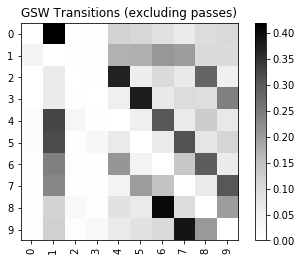

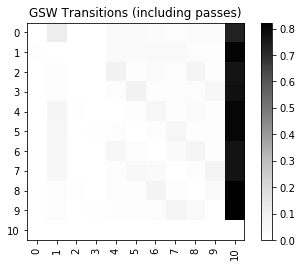

In [93]:
plt.title("GSW Transitions (excluding passes)")
plt.imshow(normalized_nopass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]), rotation=90)
plt.yticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]))
plt.show()

plt.title("GSW Transitions (including passes)")
plt.imshow(normalized_pass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]), rotation=90)
plt.yticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]))
plt.show()

In [96]:
dists = distances_to_ball("Philadelphia 76ers", p=False)
bh = get_ballhandlers(dists)

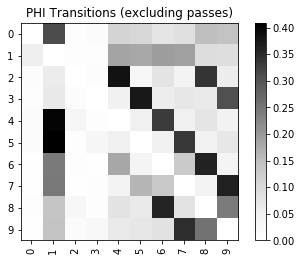

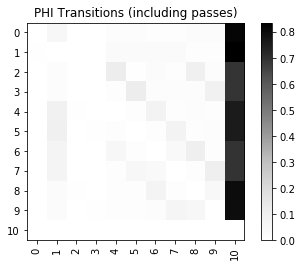

In [97]:
bh_trans = ballhandler_transitions("Philadelphia 76ers", bh, p=False)

for team, players in bh_trans.items():
    total = np.zeros((10, 10))
    for p, trans in players.items():
        nptrans = np.array(trans[0])
        total += nptrans[:10, :10]
    normalized_nopass = normalize(total, axis=1, norm="l1")
    
for team, players in bh_trans.items():
    total = np.zeros((11, 11))
    for p, trans in players.items():
        total += trans[0]
    normalized_pass = normalize(total, axis=1, norm="l1")
    
plt.title("PHI Transitions (excluding passes)")
plt.imshow(normalized_nopass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]), rotation=90)
plt.yticks(range(normalized_nopass.shape[0]), range(normalized_nopass.shape[0]))
plt.show()

plt.title("PHI Transitions (including passes)")
plt.imshow(normalized_pass, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]), rotation=90)
plt.yticks(range(normalized_pass.shape[0]), range(normalized_pass.shape[0]))
plt.show()

### Outputs distances travelled of team

In [10]:
def distance_travelled(team_name, num_games=None, p=True):
    dist_dict = {}
    seen_moments = set()
    abbrev = team_to_abbrev[team_name]

    count = 0
    for root, dirs, files in os.walk(".\data"):
        if abbrev in root:
            for fil in files:
                with open(os.path.join(root, fil)) as f:
                    if num_games and count >= num_games:
                        return dist_dict
                    if p:
                        print root
                    count += 1
                    for l in f:
                        line = json.loads(l)
                        for i in range(len(line["events"])):
                            for mom in line["events"][i]["moments"]:
                                mom_tuple = (mom[2], mom[3], mom[5][0][2], mom[5][0][3])
                                for val in mom[5]:
                                    player = val[1]
                                    if player != -1:
                                        team = val[0]
                                        if team not in dist_dict:
                                            dist_dict[team] = {}
                                        if player not in dist_dict[team]:
                                            dist_dict[team][player] = [0, val[2], val[3]]
                                        else:
                                            if mom_tuple not in seen_moments:
                                                dist = distance(val[2], val[3], dist_dict[team][player][1], dist_dict[team][player][2])
                                                dist_dict[team][player][0] += dist
                                            dist_dict[team][player][1] = val[2]
                                            dist_dict[team][player][2] = val[3]
                                seen_moments.add(mom_tuple)
    return dist_dict, count

In [11]:
team_dists = json.load(open("team_to_dists.json"))
# for team, winpct in team_to_winpct.items():
#     print team
#     if team not in team_dists:
#         dist_dict, count = distance_travelled(team, p=False)
#         for player_id, dists in sorted(dist_dict[team_to_id[team]].items(), key=lambda x:x[1][0], reverse=True):
#             if player_id > 0:
#                 print("{}: {} feet".format(id_to_player[player_id], dists[0]))
#         dist_dict[team_to_id[team]]["count"] = count
#         team_dists[team] = dist_dict[team_to_id[team]]
#         json.dump(team_dists, open("team_to_dists.json", "w"))

[(u'Kentavious Caldwell-Pope', 16665.397539864014), (u'Jimmy Butler', 16489.557476435126), (u'DeMar DeRozan', 16027.678083786375), (u'Gordon Hayward', 15918.887332717994), (u'Kemba Walker', 15788.279068328164), (u'Paul George', 15771.031353216613), (u'CJ McCollum', 15630.11353249026), (u'Khris Middleton', 15457.941732033589), (u'Brandon Knight', 15431.782210659034), (u'Marcus Morris', 15399.744096126158)]
[(u'Charlotte Hornets', 111050.84730648821), (u'Philadelphia 76ers', 110039.11274283711), (u'Portland Trail Blazers', 108936.19929515265), (u'Golden State Warriors', 108783.74764164232), (u'Sacramento Kings', 108716.60665601384), (u'Utah Jazz', 108316.26835949568), (u'Los Angeles Clippers', 106823.81733467516), (u'Los Angeles Lakers', 106690.63499003825), (u'Orlando Magic', 106675.7368545042), (u'Boston Celtics', 106491.54940869685)]
331


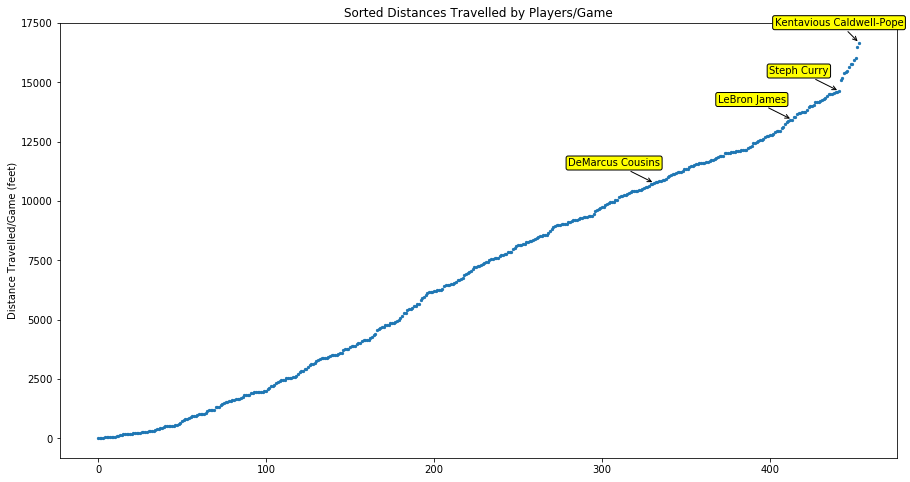

In [35]:
player_avg = []
team_avg = []
for team, players in team_dists.items():
    team_total = 0
    for player, dist in players.items():
        if player != "count" and int(player) != 0:
            player_avg.append((id_to_player[int(player)], dist[0]/players["count"]))
            team_total += dist[0]
    team_avg.append((team, team_total/players["count"]))
print sorted(player_avg, reverse=True, key=lambda x:x[1])[:10]
print sorted(team_avg, reverse=True, key=lambda x:x[1])[:10]
plt.figure(figsize=(15, 8))
print [p[0] for p in sorted(player_avg, key=lambda x:x[1])].index("DeMarcus Cousins")
sorted_avgs = [p[1] for p in sorted(player_avg, key=lambda x:x[1])]
plt.scatter(range(len(player_avg)), sorted_avgs, s=5)
plt.ylabel("Distance Travelled/Game (feet)")
plt.title("Sorted Distances Travelled by Players/Game")
plt.annotate("Kentavious Caldwell-Pope", xy=(range(len(player_avg))[-1], sorted_avgs[-1]), xytext=(-20, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate("Steph Curry", xy=(range(len(player_avg))[441], sorted_avgs[441]), xytext=(-40, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate("LeBron James", xy=(range(len(player_avg))[413], sorted_avgs[413]), xytext=(-40, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.annotate("DeMarcus Cousins", xy=(range(len(player_avg))[331], sorted_avgs[331]), xytext=(-40, 20), 
             textcoords='offset points', ha='center', va='center', 
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1), 
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
#plt.annotate("CJ", (range(len(player_avg))[-1], sorted_avgs[-1]))
plt.show()

Correlation Coefficient: -0.301808051121, P-value: 0.10504290953


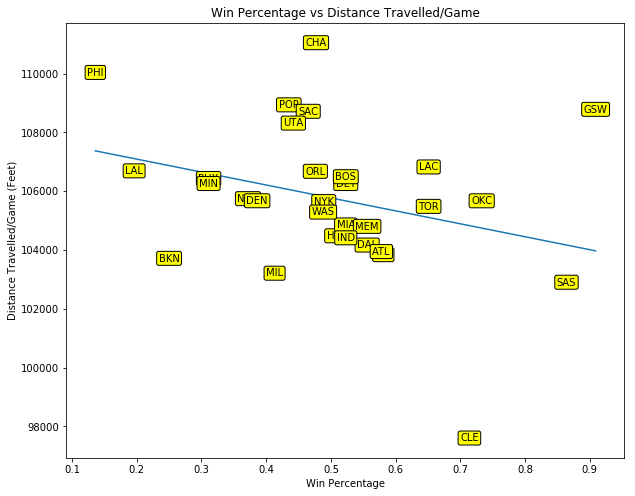

In [13]:
winpcts = [team_to_winpct[tup[0]] for tup in team_avg]
distances = [tup[1] for tup in team_avg]
teams = [team_to_abbrev[tup[0]] for tup in team_avg]

corr = scipy.stats.pearsonr(distances, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])

plt.figure(figsize=(10, 8))
plt.scatter(winpcts, distances, marker='o')

for team, x, y in zip(teams, winpcts, distances):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, distances, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Distance Travelled/Game")
plt.xlabel("Win Percentage")
plt.ylabel("Distance Travelled/Game (Feet)")
plt.show()

In [14]:
# check last possessors to determine possession
def count_possessions(dists, bhs, team):
    pos = 0
    last_pos = [bh[2] for bh in bhs[:45]]
    handler = None
    for bh in bhs[45:]:
        if bh[2] != handler:
            if all(bh[2] == pos for pos in last_pos):
                handler = bh[2]
                if handler == team_to_id[team]:
                    pos += 1
        last_pos = last_pos[1:]+[bh[2]]
    return pos

In [15]:
team_to_poss = json.load(open("team_to_poss.json"))
# for team, players in team_dists.items():
#     if team not in team_to_poss:
#         count = players["count"]
#         dists = distances_to_ball(team, team_specific=False, p=False)
#         bhs = get_ballhandlers(dists)
#         team_to_poss[team] = count_possessions(dists, bhs, team)/float(count)
#         json.dump(team_to_poss, open("team_to_poss.json", "w"))

Correlation Coefficient: -0.210232619375, P-value: 0.264815432582


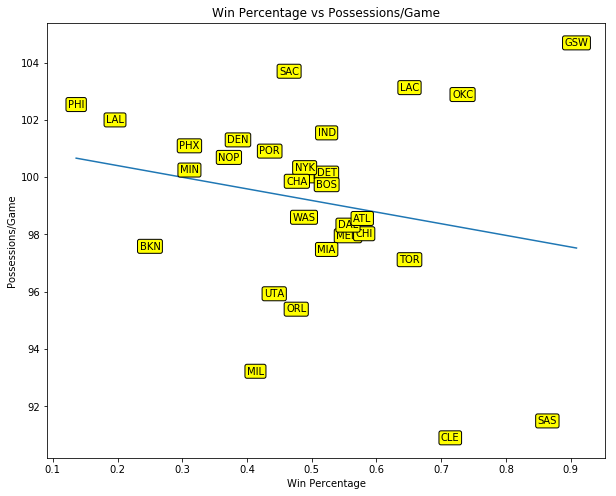

In [16]:
winpcts = []
possessions = []
labels = []
for team, poss in team_to_poss.items():
    winpcts.append(team_to_winpct[team])
    possessions.append(poss)
    labels.append(team_to_abbrev[team])
    
corr = scipy.stats.pearsonr(possessions, winpcts)
print "Correlation Coefficient: {}, P-value: {}".format(corr[0], corr[1])
    
plt.figure(figsize=(10, 8))
plt.scatter(winpcts, possessions, marker='o')

for team, x, y in zip(labels, winpcts, possessions):
    plt.annotate(team, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='center', va='center', 
                 bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1))
plt.plot(np.unique(winpcts), np.poly1d(np.polyfit(winpcts, possessions, 1))(np.unique(winpcts)))
plt.title("Win Percentage vs Possessions/Game")
plt.xlabel("Win Percentage")
plt.ylabel("Possessions/Game")
plt.show()